In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# set theme
sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "figure.figsize": (7.0, 3.5),
        "savefig.dpi": 300,
        "figure.autolayout": True,
    },
)


fig_path = Path("../figures")
model = "1sybsz6w"

# Load Data

In [2]:
dfs = []
for policy_path in (fig_path / "test_results").iterdir():
    if not policy_path.is_dir():
        continue
    if not model in policy_path.name:
        continue
    rewards = np.load(policy_path / "rewards.npy")
    n_trials, n_steps = rewards.shape
    trial_idx, step_idx = np.mgrid[:n_trials, :n_steps]
    dfs.append(
        pd.DataFrame(
            {
                "experiment": policy_path.name[len(model)+1:],
                "trial_idx": trial_idx.flatten(),
                "step_idx": step_idx.flatten(),
                "reward": rewards.flatten(),
            }
        )
    )
df = pd.concat(dfs)
df.head()

,experiment,trial_idx,step_idx,reward
0,30.0-a,0,0,0.0
1,30.0-a,0,1,0.0
2,30.0-a,0,2,0.0
3,30.0-a,0,3,0.0
4,30.0-a,0,4,0.0


# Plots (Constant Area)

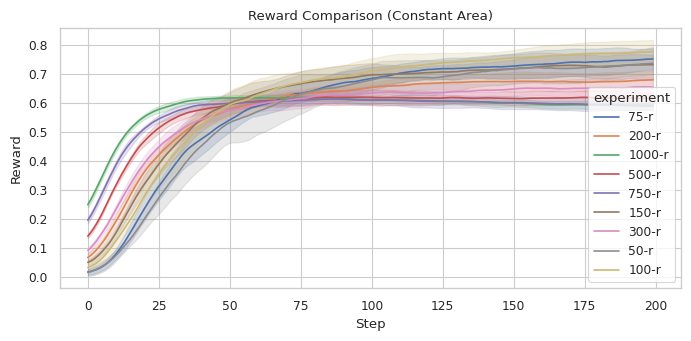

In [3]:
# Create the line plot
area_df = df[df["experiment"].str[-1] == "r"]

sns.lineplot(
    data=area_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Comparison (Constant Area)")

# Save the plot
plt.savefig(fig_path / "transfer_area.png")
plt.savefig(fig_path / "transfer_area.pdf")
plt.show()

/tmp/ipykernel_1350384/2880340428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_final["num_agents"] = area_final["experiment"].str[:-2].astype(int)


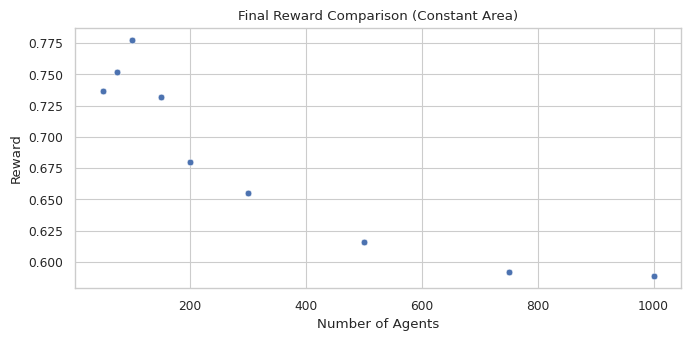

In [4]:
# Create the comparison of final rewards
area_final = area_df[area_df["step_idx"] == 199]
area_final["num_agents"] = area_final["experiment"].str[:-2].astype(int)
area_final = area_final[["num_agents", "reward"]].groupby(["num_agents"]).mean()

sns.scatterplot(
    data=area_final,
    x="num_agents",
    y="reward",
)
plt.xlabel("Number of Agents")
plt.ylabel("Reward")
plt.title("Final Reward Comparison (Constant Area)")

# Save the plot
plt.savefig(fig_path / "transfer_area_final.png")
plt.savefig(fig_path / "transfer_area_final.pdf")
plt.show()

# Plots (Constant Number of Agents)

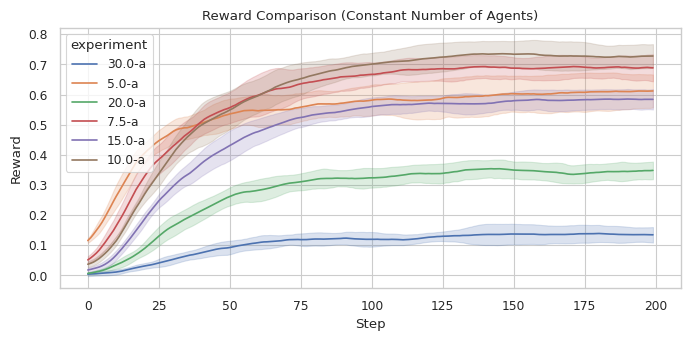

In [5]:
# Create the line plot
agents_df = df[df["experiment"].str[-1] == "a"]

sns.lineplot(
    data=agents_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Comparison (Constant Number of Agents)")

# Save the plot
plt.savefig(fig_path / "transfer_agents.png")
plt.savefig(fig_path / "transfer_agents.pdf")
plt.show()

/tmp/ipykernel_1350384/1457671146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agents_final["width"] = agents_final["experiment"].str[:-2].astype(float)


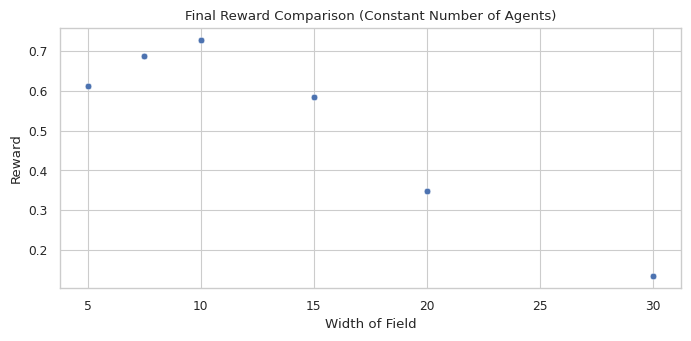

In [6]:
# Create the comparison of final rewards
agents_final = agents_df[agents_df["step_idx"] == 199]
agents_final["width"] = agents_final["experiment"].str[:-2].astype(float)
agents_final = agents_final[["width", "reward"]].groupby(["width"]).mean()

sns.scatterplot(
    data=agents_final,
    x="width",
    y="reward",
)
plt.xlabel("Width of Field")
plt.ylabel("Reward")
plt.title("Final Reward Comparison (Constant Number of Agents)")

# Save the plot
plt.savefig(fig_path / "transfer_agents_final.png")
plt.savefig(fig_path / "transfer_agents_final.pdf")
plt.show()

# Plots (Constant Density)

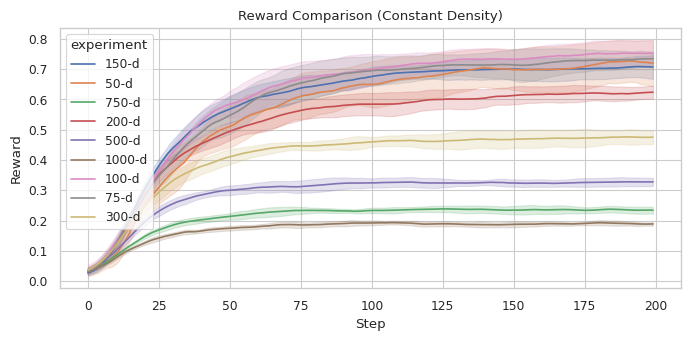

In [7]:
# Create the line plot
density_df = df[df["experiment"].str[-1] == "d"]

sns.lineplot(
    data=density_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Comparison (Constant Density)")

# Save the plot
plt.savefig(fig_path / "transfer_density.png")
plt.savefig(fig_path / "transfer_density.pdf")
plt.show()

/tmp/ipykernel_1350384/2700899460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  density_final["num_agents"] = density_final["experiment"].str[:-2].astype(int)


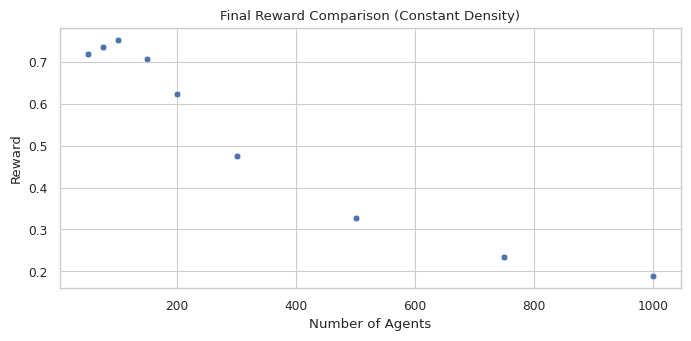

In [8]:
# Create the comparison of final rewards
density_final = density_df[density_df["step_idx"] == 199]
density_final["num_agents"] = density_final["experiment"].str[:-2].astype(int)
density_final = density_final[["num_agents", "reward"]].groupby(["num_agents"]).mean()

sns.scatterplot(
    data=density_final,
    x="num_agents",
    y="reward",
)
plt.xlabel("Number of Agents")
plt.ylabel("Reward")
plt.title("Final Reward Comparison (Constant Density)")

# Save the plot
plt.savefig(fig_path / "transfer_density_final.png")
plt.savefig(fig_path / "transfer_density_final.pdf")
plt.show()